# Monocle analysis of single-cell sequencing of influenza-infected cells
Study by Alistair Russell, [Cole Trapnell](http://cole-trapnell-lab.github.io/), and [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

This notebook starts with the annotated cell-gene matrix, and analyzes the expression of influenza-infected cells in various ways. 
It primarily does this using [Monocle](http://cole-trapnell-lab.github.io/monocle-release/)​.

## Setup 
Load or install necessary packages.
Cole suggested that we might want to install the development version of [Monocle](http://cole-trapnell-lab.github.io/monocle-release/) from GitHub; right now this does **not** do this.

In [1]:
# install packages
if (suppressMessages((!require("monocle", quietly=TRUE)))) {
  source("http://bioconductor.org/biocLite.R", suppressUpdates=TRUE)
  biocLite()
  biocLite("monocle", suppressWarnings=TRUE)
}
cat("Using monocle version", package.version("monocle"))
if (!require("pacman", quietly=TRUE)) 
  install.packages("pacman")
pacman::p_load("ggplot2", "ggthemes", "ggExtra", "cowplot", "scales", "reshape2", "dplyr", 
  "magrittr", "rmarkdown", "IRdisplay")

# plots will be saved here
plotsdir <- './results/plots/'
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir)    
    
fancy_scientific <- function(x) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  x %>% format(scientific=TRUE) %>% gsub("^0e\\+00","0", .) %>% gsub("^1e\\+00", "1", .) %>%
    gsub("^(.*)e", "'\\1'e", .) %>% gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% parse(text=.)
}

Using monocle version 2.4.0

## Create cell-gene dataset and examine basic statistics about number of influenza and cellular mRNAs per cell
Read in cell-gene data for all samples.
This is the merged cell-gene data set constructed with `cellranger` using the iPython notebook.
The cells are annotated by the number of wildtype and synonymous-barcoded influenza UMIs called for each cell.

In [2]:
matrixfile <- "results/cellgenecounts/merged_humanplusflu_matrix.mtx"
genesfile <- "results/cellgenecounts/merged_humanplusflu_genes.tsv"
cellsfile <- "results/cellgenecounts/merged_humanplusflu_cells.tsv"

all.cells <- newCellDataSet(readMM(matrixfile),
  phenoData=new("AnnotatedDataFrame", data=read.delim(cellsfile)),
  featureData=new("AnnotatedDataFrame", data=read.delim(genesfile)),
  expressionFamily=negbinomial.size())

Filter on the samples that interest us.
Right now this is all the samples in the cell-gene dataset.

In [3]:
samples = c("Uninfected", "6hr-1", "8hr-2", "8hr-2repeat", "10hr-2")

cells <- all.cells[, row.names(subset(pData(all.cells), Sample %in% samples))]

cat("Filtered all", nrow(pData(all.cells)), "cells down to the", nrow(pData(cells)),
  "in samples of interest.")

Filtered all 16746 cells down to the 16746 in samples of interest.

Compute the number of total mRNAs, cellular mRNAs, influenza mRNAs, and fraction of influenza mRNAs per cell.

In [4]:
pData(cells)$total.mRNAs <- Matrix::colSums(exprs(cells))

flugenes <- c("fluPB2", "fluPB1", "fluPA", "fluHA", "fluNP", "fluNA", "fluM", "fluNS")
flugenes.id <- row.names(subset(fData(cells), gene_short_name %in% flugenes))
pData(cells)$flu.mRNAs <- Matrix::colSums(exprs(cells[flugenes.id,]))

pData(cells)$frac.flu.mRNAs <- pData(cells)$flu.mRNAs / pData(cells)$total.mRNAs

cellgenes.id <- row.names(subset(fData(cells), !(gene_short_name %in% flugenes)))
pData(cells)$cellular.mRNAs <- Matrix::colSums(exprs(cells[cellgenes.id,]))

Plot the number of influenza mRNAs versus the number of cellular RNAs.
The blue curves show the overall density of the number of cellular mRNAs.
Note that different samples were sequenced to somewhat different depths.

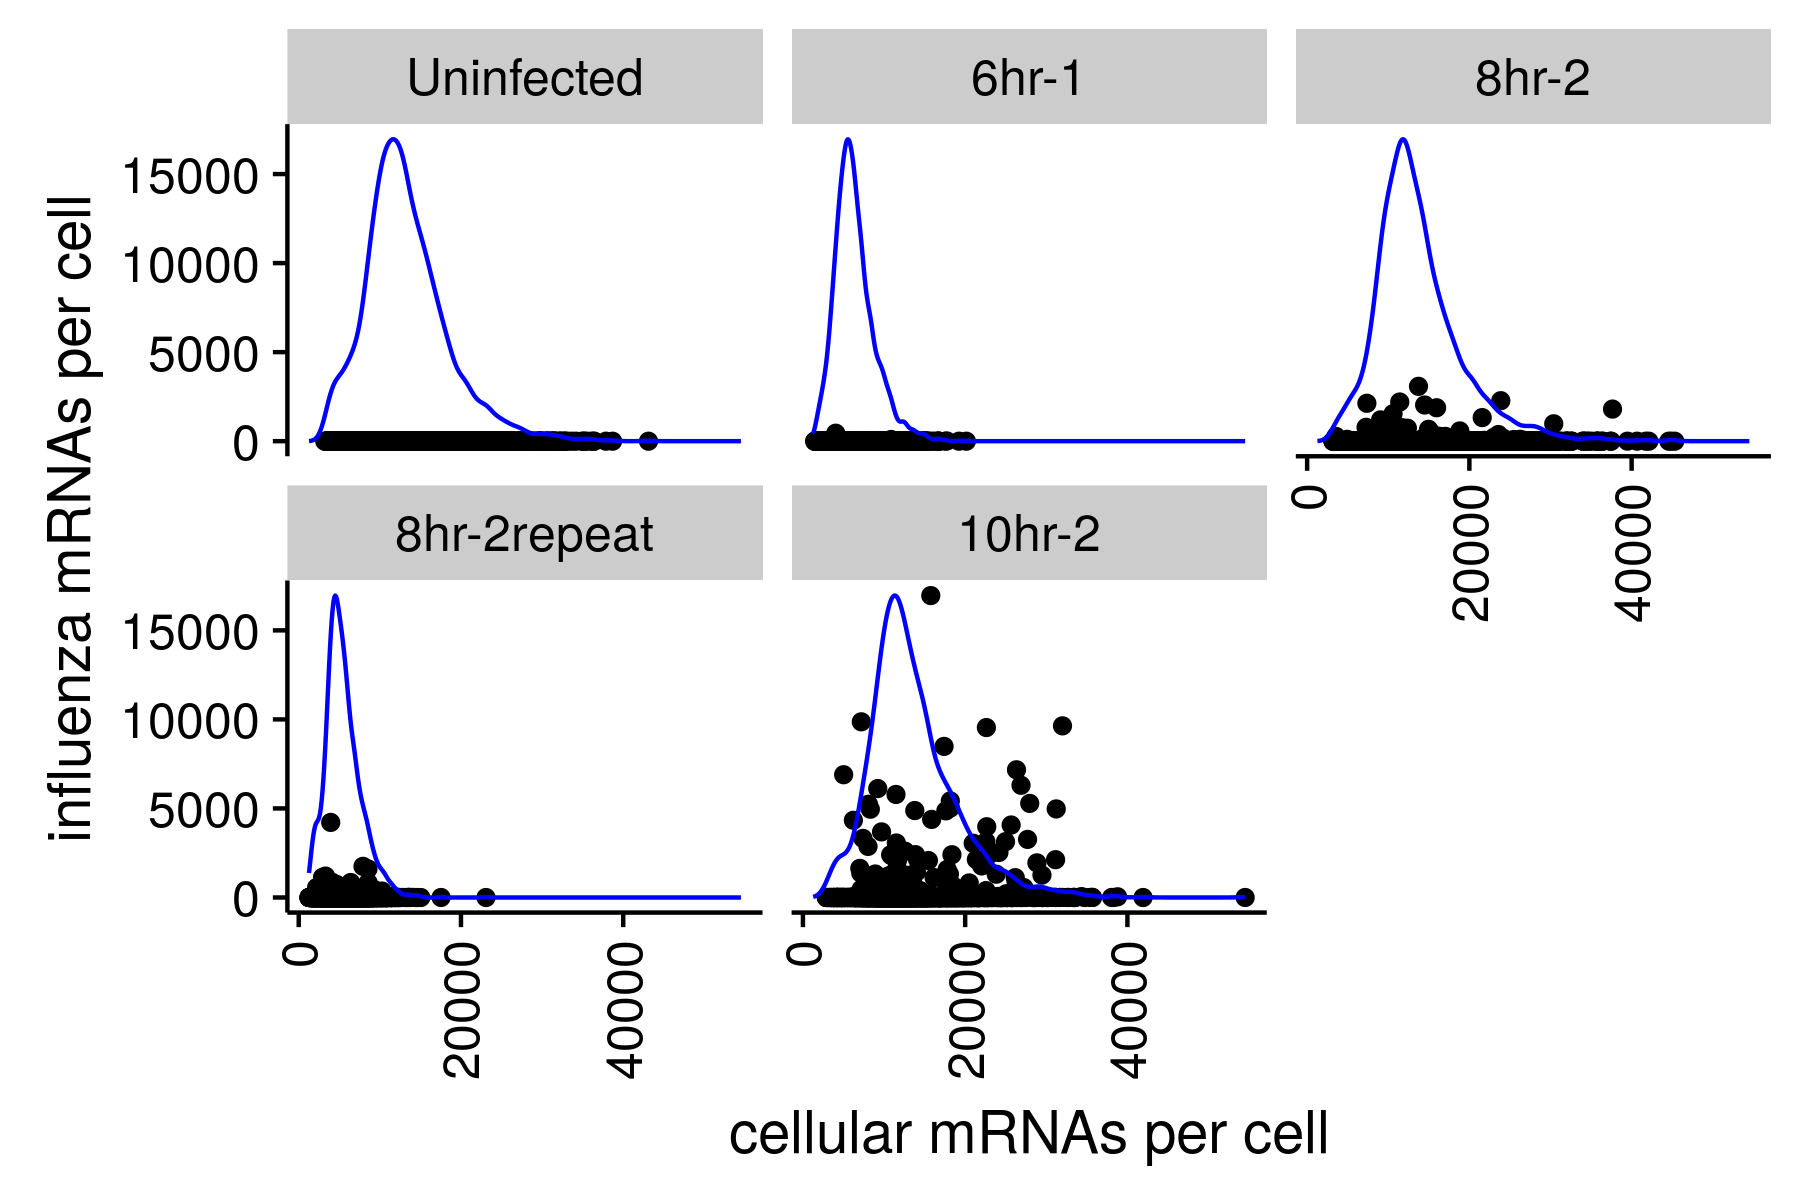

In [5]:
scatterplot <- ggplot(
    transform(pData(cells), Sample=factor(Sample, levels=samples)), # order by sample
    aes(cellular.mRNAs, flu.mRNAs)) +
  geom_point()

# use eval substitute to get value of maxy as here: https://stackoverflow.com/a/10659563
densityplot <- eval(substitute(
  {stat_density(aes(x=cellular.mRNAs, y=maxy*(..scaled..)), geom="line", color='blue')},
  list(maxy=layer_scales(scatterplot)$y$range$range[2])))

p <- scatterplot + densityplot + theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
  facet_wrap(~Sample) + xlab("cellular mRNAs per cell") + ylab("influenza mRNAs per cell")

plotfile <- file.path(plotsdir, "mRNA_counts_flu_vs_cellular.png")
ggsave(plotfile, plot=p, width=6, height=4, units="in")
display_png(file=plotfile, width=600)

The `Monocle` vignette suggests filtering cells with far more / less mRNAs than most cells.
I have **not** done that because it filters out a lot of the influenza-infected cells.
This fact is made more clear by the next plot, which shows that cells with >1% of their mRNAs from influenza tend to have more total mRNAs than other cells.
I can think of several possible explanations:

  1. Influenza preferentially infects bigger cells.

  2. Influenza infection leads cells to produce more mRNAs.

  2. Influenza infection preferentially causes "doublets"" due to cell clumping, perhaps mediated by hemagglutinin-based cross-linking of cells.

In any case, it seems safer **not** to exclude the influenza-infected cells as we'd then be preferentially excluded cells with high viral burden.

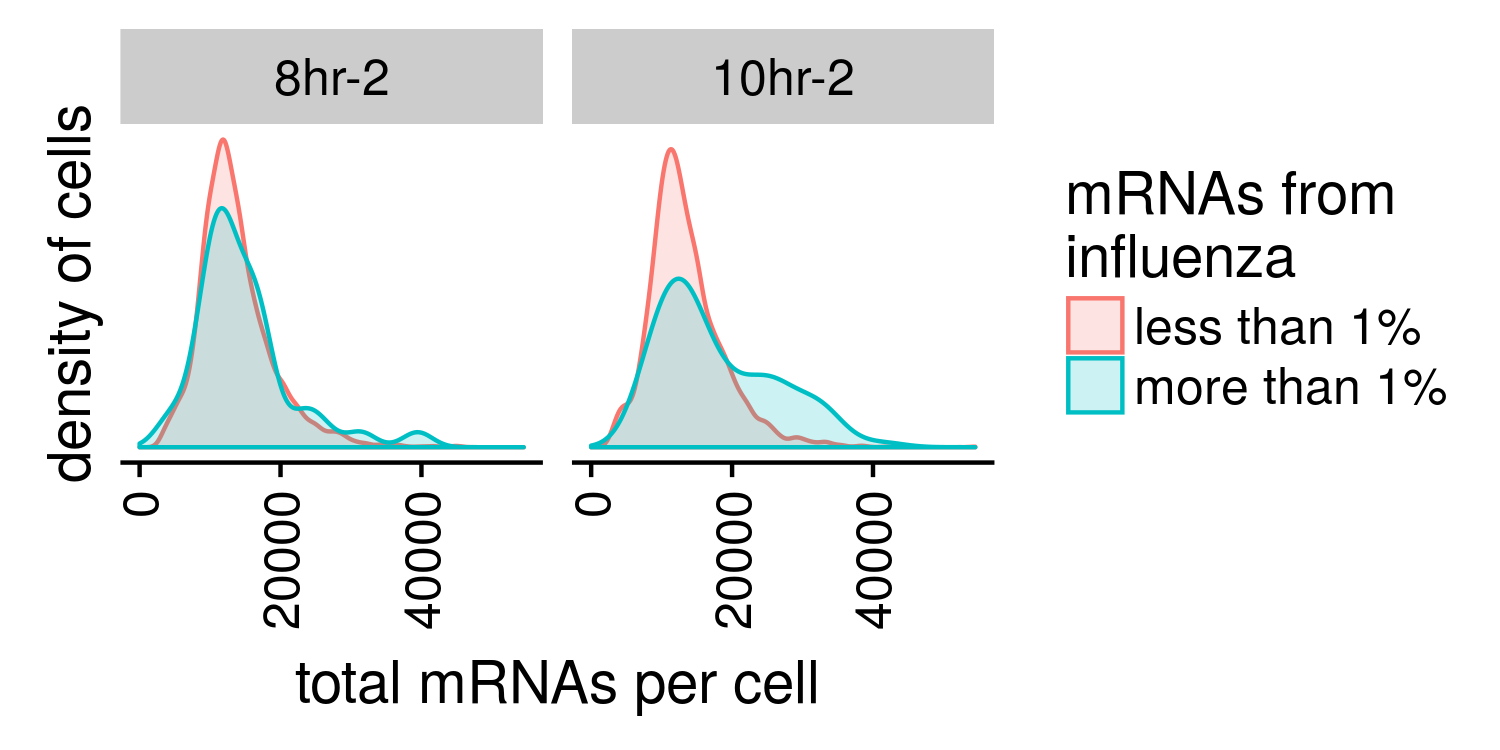

In [6]:
pData(cells)$frac.flu.0.01 <- ifelse(pData(cells)$frac.flu.mRNAs > 0.01,
  "more than 1%", "less than 1%")

# just plot samples with most flu 
samples.to.plot = c("8hr-2", "10hr-2")
p <- ggplot(
    transform(pData(cells[, row.names(subset(pData(cells), Sample %in% samples.to.plot))]),
      Sample=factor(Sample, samples)), 
    aes(total.mRNAs, color=frac.flu.0.01, fill=frac.flu.0.01)) +
  geom_density(alpha=0.2) +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
  scale_y_continuous(label=NULL, name="density of cells", breaks=NULL, limits=c(0, NA)) +
  scale_x_continuous(limits=c(0, NA)) +
  xlab("total mRNAs per cell") +
  labs(color="mRNAs from\ninfluenza", fill="mRNAs from\ninfluenza") +
  facet_wrap(~Sample)

plotfile <- file.path(plotsdir, "mRNAs_per_cell.png")
ggsave(plotfile, plot=p, width=5, height=2.5, units="in")
display_png(file=plotfile, width=500)

Here are some cumulative distribution plots showing the fraction of mRNAs derived from influenza across cells for each sample.
For the 6 and 8 hour timepoints, less than a quarter of cells have any appreciable influenza mRNAs.
For the 10 hour timepoint, about a quarter the cells have at least a tiny fraction of influenza mRNAs, but only about 10% have more than 0.1% of mRNAs from influenza.

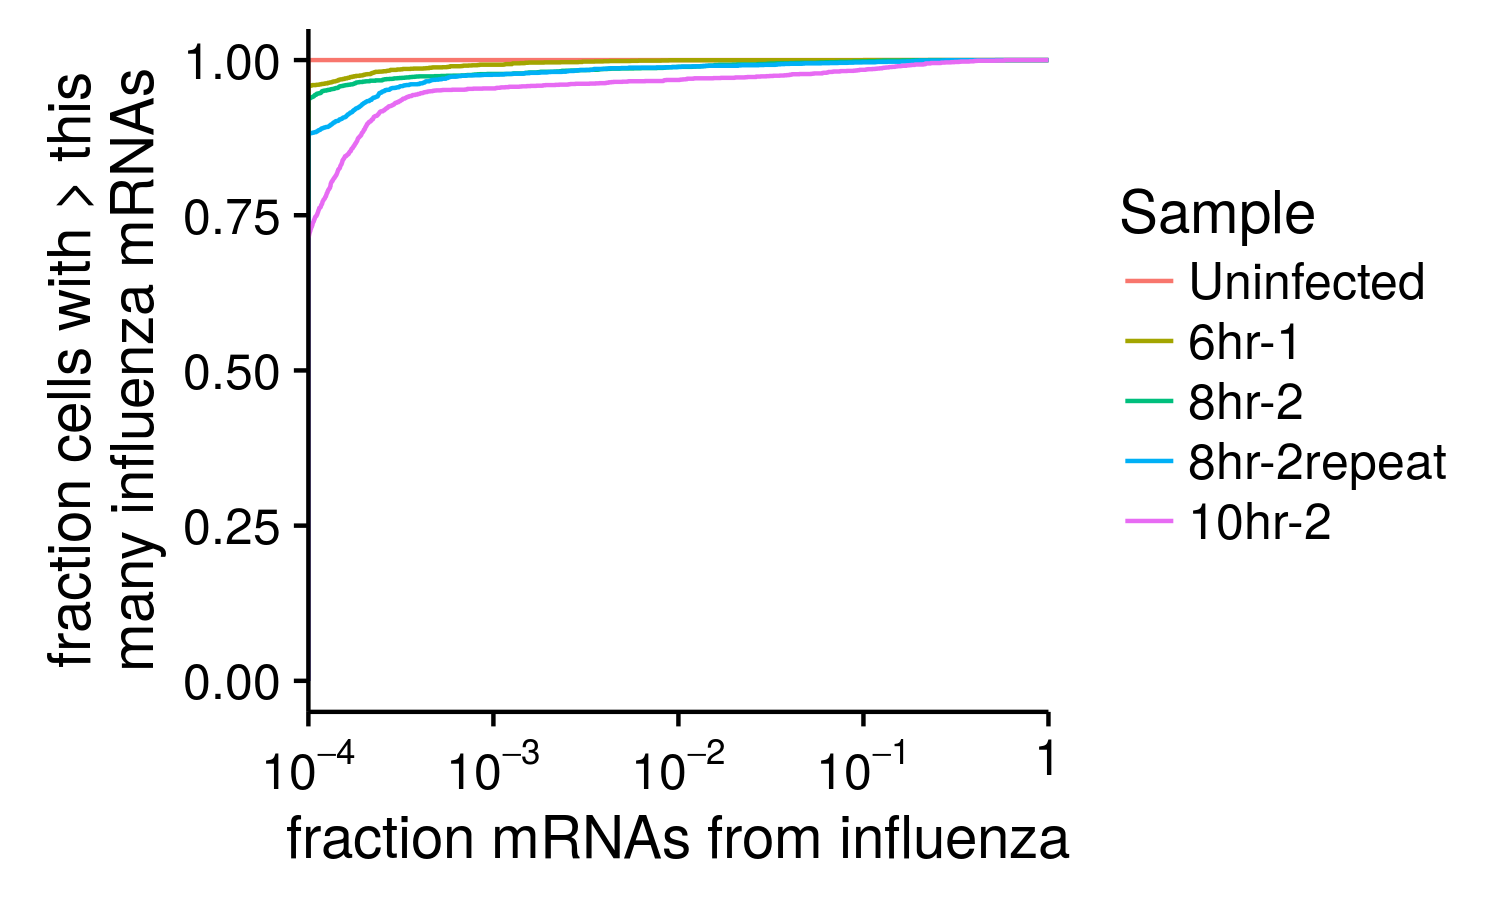

In [7]:
# some trickery around x minimum to avoid taking log of 0 while plotting x on log scale
minx <- 1e-4 # minimum value on y-axis
pData(cells)$log.frac.flu <- ifelse(pData(cells)$frac.flu.mRNAs < minx, log10(minx), 
  log10(pData(cells)$frac.flu.mRNAs))

p <- ggplot(
    transform(pData(cells), Sample=factor(Sample, samples)), # order by sample 
    aes(log.frac.flu, color=Sample)) +
  stat_ecdf() +
  scale_x_continuous(labels=function(x){fancy_scientific(10**x)},
    limits=c(log10(minx), 0), expand=c(0, 0), name="fraction mRNAs from influenza") +
  scale_y_continuous(limits=c(0, 1), name="fraction cells with > this\nmany influenza mRNAs")

plotfile <- file.path(plotsdir, "mRNAs_per_cell_cumul.png")
ggsave(plotfile, plot=p, width=5, height=3, units="in")
display_png(file=plotfile, width=500)

## Look at levels of influenza genes, using synonymous barcodes to detect co-infection and mRNA leakage
Roughly half of the infecting influenza viruses had a synonymous barcode at the 3' end of each mRNA.
If cells infected by a single virus (which we expect to be the most common case for infected cells since infection itself is rare), then they should generally have either all wildtype or all synonymously barcoded viruses.
Looking for deviations from this expectation can identify both true co-infection and cells that just got some influenza mRNA by leakage, since such leakage is expected to introduce a mix of both wildtype and synonymously barcoded.
Establishing when cells start to have influenza mRNA due to true infection versus simple leakage is important for figuring out the actual variation in influenza mRNA levels in truly infected cells.

Note that we have counted influenza mRNAs from the standard 10X sequencing of the full transcriptome.
However, we have also called the synonymous versus wildtype barcodes using some extra semi-specific PCR which is not included in the cell-gene count data due to the fact that it is biased towards some genes, but does provide extra depth on the barcode counts.
We limit the analysis below to cells that meet the following criteria:

  1. They have at least two influenza reads in the cell-gene matrix.

  2. They have at least two called barcodes (synonymous or wildtype) in the cell-gene matrix plus extra semi-specific PCR.

These criteria are a way to limit the analysis just to cells where there is actual information about the synonymous barcodes.
First, we filter down to these cells and plot some information about them.
Note that these plots show the number of influenza mRNAs on a log scale, and then color the bars by the fraction of reads from each barcode.
So the heights of each color in the bars are proportional to the fraction of the reads with that barcode, they are **not** the log of the number of reads with each barcode.

Warning message in `[<-.factor`(`*tmp*`, list, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, list, value = 0):
“invalid factor level, NA generated”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


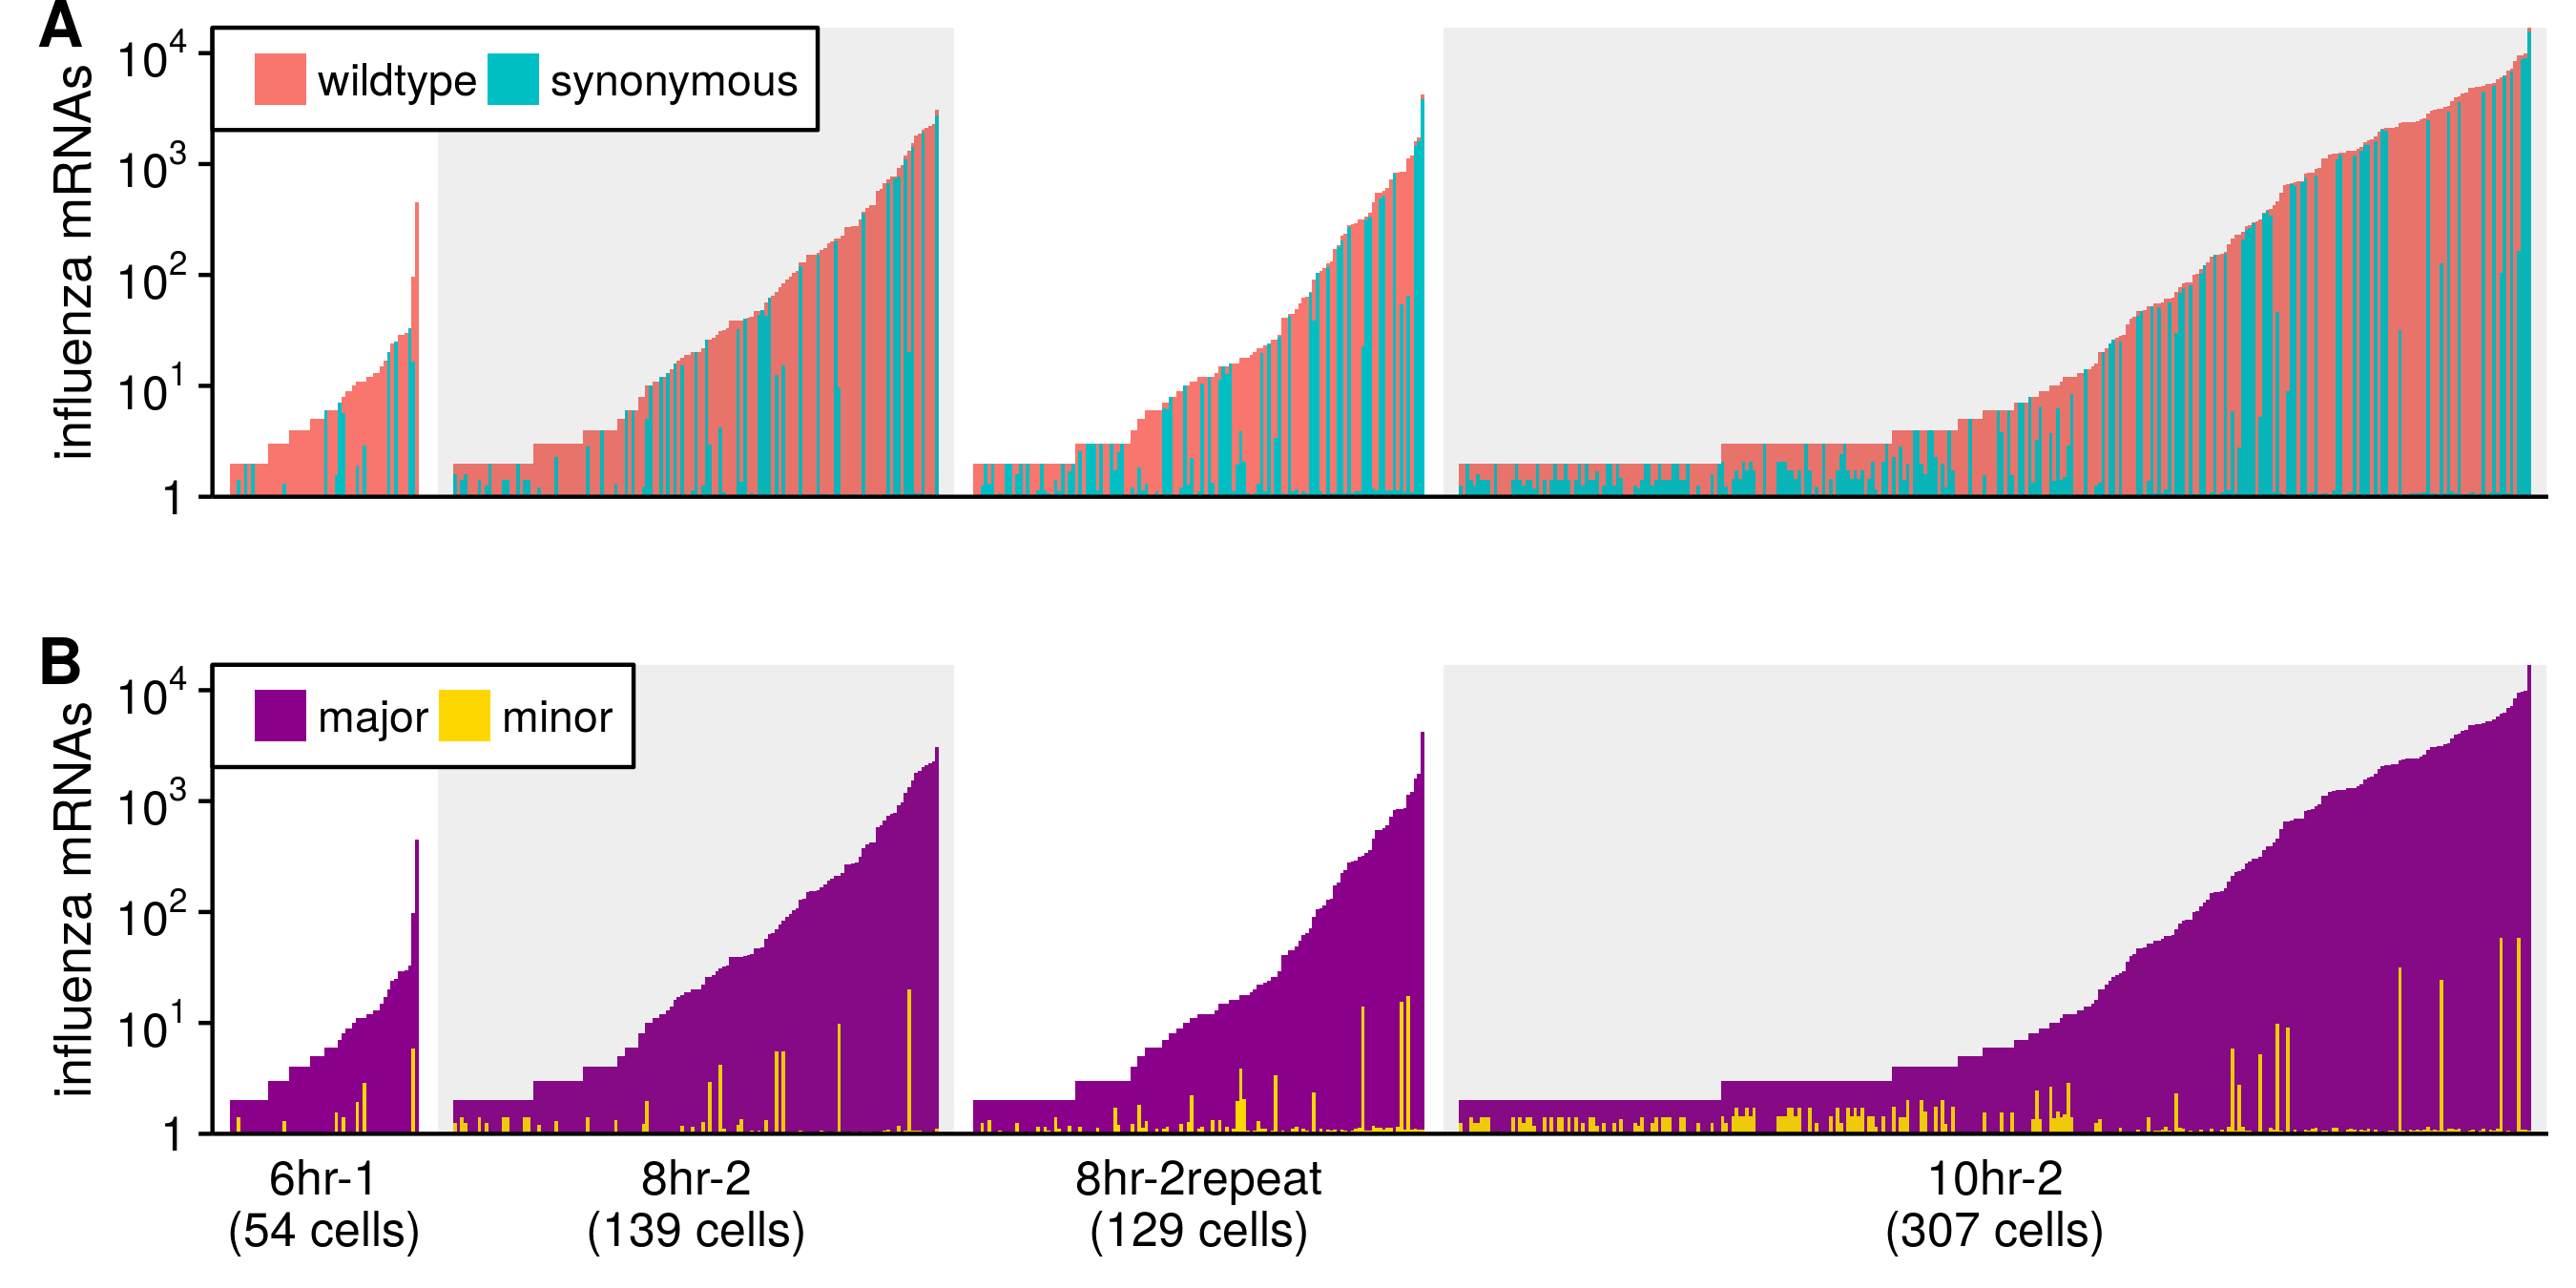

In [8]:
# filter on sufficiently barcoded cells and samples with such cells
bc.cells <- filter(pData(cells), flu.mRNAs >= 2, flu.wt + flu.syn >= 2)
samples.to.plot <- bc.cells[["Sample"]] %>% unlist %>% unique

# make variables with product of log flu mRNAs times fraction with each barcode
bc.cells <- bc.cells %>% mutate(frac.wt=(flu.wt / (flu.wt + flu.syn))) %>%
  mutate(wildtype=log10(flu.mRNAs) * frac.wt, synonymous=log10(flu.mRNAs) * (1 - frac.wt)) %>%
  mutate(major=pmax(wildtype, synonymous), minor=pmin(wildtype, synonymous))

# make some dummy rows with 0 or many influenza to "pad" between samples on the plot
npad <- 5 # pad this many cells on each side of each sample
bc.cells <- lapply(samples.to.plot, function(s) {data.frame(Sample=rep(s , 2 * npad), 
    flu.mRNAs=c(rep(0, npad), rep(1e8, npad)))}) %>%
  bind_rows(., bc.cells) %>% mutate_each(funs(replace(., is.na(.), 0)))

# order bc_cells by sample and flu abundance
bc.cells$Sample <- factor(bc.cells$Sample, samples.to.plot)
bc.cells <- arrange(bc.cells, Sample, flu.mRNAs)
bc.cells$indx <- as.numeric(row.names(bc.cells))

# get min and max indx for each sample
indxrange <- bc.cells %>% filter(major > 0) %>% group_by(Sample) %>% 
  summarize(imax=max(indx), imin=min(indx)) %>%
  mutate(center=(imin + imax) / 2, label=sprintf("%s\n(%d cells)", Sample, imax - imin + 1))

purityplot <- function (barcodes) {
  # plot purity of barcoded cells using barcode type specified by *barcodes*
  ggplot(melt(bc.cells, id.vars=c("indx", "Sample"), measure.vars=barcodes, variable.name="barcode"),
    aes(x=indx, y=value)) +
  geom_bar(aes(fill=barcode), stat="identity", position="stack", width=1) +
  scale_y_continuous(name="influenza mRNAs", expand=c(0, 0), labels=function(y){fancy_scientific(10**y)}) +
  scale_x_continuous(expand=c(0, 0), name=NULL, breaks=indxrange$center, labels=indxrange$label) +
  theme(text=element_text(size=13), axis.ticks.x=element_blank(), legend.position=c(0, 1),
    legend.justification=c(0, 1), legend.direction="horizontal",
    legend.background=element_rect(fill="white", size=0.5, linetype="solid", color="black")) +
  scale_fill_discrete("") +
  geom_rect(data=data.frame(xmin=indxrange$imin[seq(2, nrow(indxrange), 2)] - npad,
    xmax=indxrange$imax[seq(2, nrow(indxrange), 2)] + npad, ymin=-Inf, ymax=Inf),
    aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.1, inherit.aes=FALSE)
}

p.wt.syn <- purityplot(c("wildtype", "synonymous"))
p.major.minor <- purityplot(c("major", "minor"))
p <- plot_grid(p.wt.syn + theme(axis.text.x=element_blank()),
  p.major.minor + scale_fill_manual(values=c("darkmagenta", "gold"), name=NULL),
    nrow=2, align='h', labels="AUTO", label_size=16, vjust=1)

plotfile <- file.path(plotsdir, "flu_barcode_purity.png")
ggsave(plotfile, plot=p, width=9, height=4.5, units="in")
display_png(file=plotfile, width=900)